## Time-series based analysis of Earthquake Risk Factors

### Part 3: Performing EDA on the pickled reddit dataset

In this notebook, I explore several aspects of the dataframe and also prepare the dataframe objects for further modeling.

Importing the required libraries:

In [13]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

### Part 2.1: Importing the saved clean data from reddit API and cleaning

In [14]:
file_path = "../datasets/" + "eq_loma_prieta" + "_clean" + ".csv"

df_eq = pd.read_csv(file_path)
df_eq.drop(columns = "Unnamed: 0", inplace = True)

df_eq.set_index('time', inplace=True)




df_eq.head()

,index,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
time,,,,,,,,,,,,,,,,
1989-10-18 23:52:57.010,0,earthquake,1.42,Northern California,reviewed,0,31,nc,11.0,0.02342,0.03,70.0,md,-121.945167,37.148333,6.129
1989-10-18 23:50:19.750,1,earthquake,1.85,Northern California,reviewed,0,53,nc,22.0,0.02523,0.05,74.0,md,-121.723333,36.965000,13.466
1989-10-18 23:42:27.610,2,earthquake,1.98,Northern California,reviewed,0,60,nc,35.0,0.02973,0.07,55.0,md,-122.032833,37.194500,11.406
1989-10-18 23:37:54.640,3,earthquake,2.09,Northern California,reviewed,0,67,nc,28.0,0.02252,0.05,69.0,md,-121.854167,37.092500,7.679
1989-10-18 23:33:41.010,4,earthquake,1.65,Northern California,reviewed,0,42,nc,17.0,0.03423,0.07,59.0,md,-121.636333,36.985500,0.856


In [15]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 1989-10-18 23:52:57.010 to 1989-10-15 00:46:56.360
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1038 non-null   int64  
 1   type       1038 non-null   object 
 2   mag        1038 non-null   float64
 3   place      1038 non-null   object 
 4   status     1038 non-null   object 
 5   tsunami    1038 non-null   int64  
 6   sig        1038 non-null   int64  
 7   net        1038 non-null   object 
 8   nst        1037 non-null   float64
 9   dmin       997 non-null    float64
 10  rms        1037 non-null   float64
 11  gap        1037 non-null   float64
 12  magType    1038 non-null   object 
 13  longitude  1038 non-null   float64
 14  latitude   1038 non-null   float64
 15  depth      1038 non-null   float64
dtypes: float64(8), int64(3), object(5)
memory usage: 137.9+ KB


In [16]:
# Taking care of time index
df_eq.index = pd.to_datetime(df_eq.index)

df_eq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1038 entries, 1989-10-18 23:52:57.010000 to 1989-10-15 00:46:56.360000
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1038 non-null   int64  
 1   type       1038 non-null   object 
 2   mag        1038 non-null   float64
 3   place      1038 non-null   object 
 4   status     1038 non-null   object 
 5   tsunami    1038 non-null   int64  
 6   sig        1038 non-null   int64  
 7   net        1038 non-null   object 
 8   nst        1037 non-null   float64
 9   dmin       997 non-null    float64
 10  rms        1037 non-null   float64
 11  gap        1037 non-null   float64
 12  magType    1038 non-null   object 
 13  longitude  1038 non-null   float64
 14  latitude   1038 non-null   float64
 15  depth      1038 non-null   float64
dtypes: float64(8), int64(3), object(5)
memory usage: 137.9+ KB


In [17]:
df_eq.head()

,index,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
time,,,,,,,,,,,,,,,,
1989-10-18 23:52:57.010,0,earthquake,1.42,Northern California,reviewed,0,31,nc,11.0,0.02342,0.03,70.0,md,-121.945167,37.148333,6.129
1989-10-18 23:50:19.750,1,earthquake,1.85,Northern California,reviewed,0,53,nc,22.0,0.02523,0.05,74.0,md,-121.723333,36.965000,13.466
1989-10-18 23:42:27.610,2,earthquake,1.98,Northern California,reviewed,0,60,nc,35.0,0.02973,0.07,55.0,md,-122.032833,37.194500,11.406
1989-10-18 23:37:54.640,3,earthquake,2.09,Northern California,reviewed,0,67,nc,28.0,0.02252,0.05,69.0,md,-121.854167,37.092500,7.679
1989-10-18 23:33:41.010,4,earthquake,1.65,Northern California,reviewed,0,42,nc,17.0,0.03423,0.07,59.0,md,-121.636333,36.985500,0.856


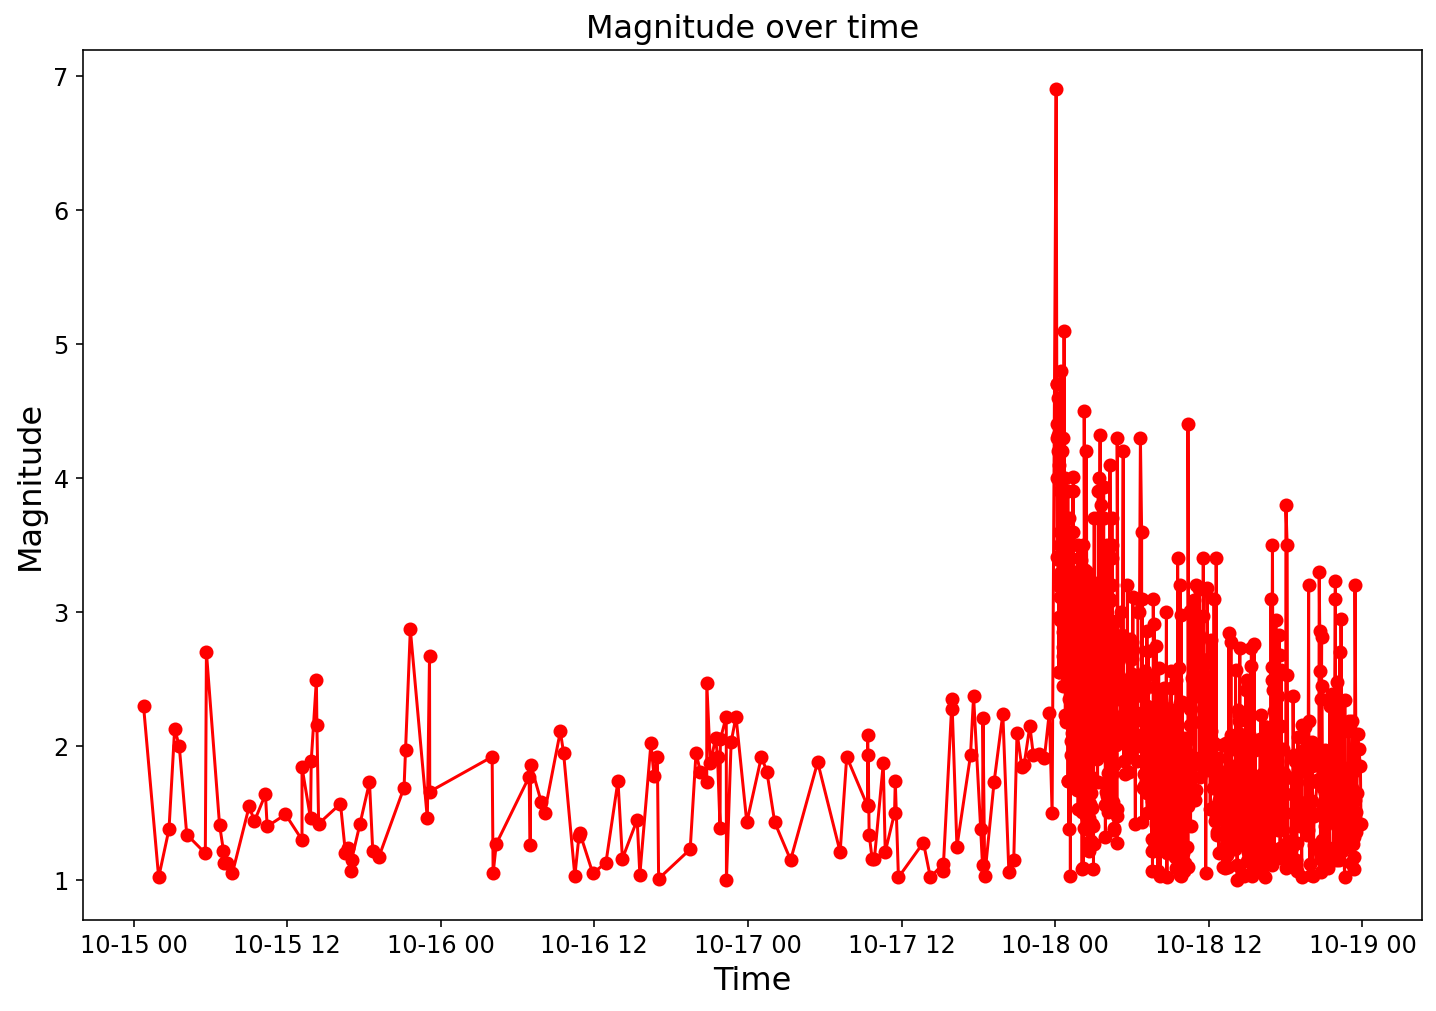

In [25]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_eq["mag"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)

plt.title('Magnitude over time', fontsize=16);

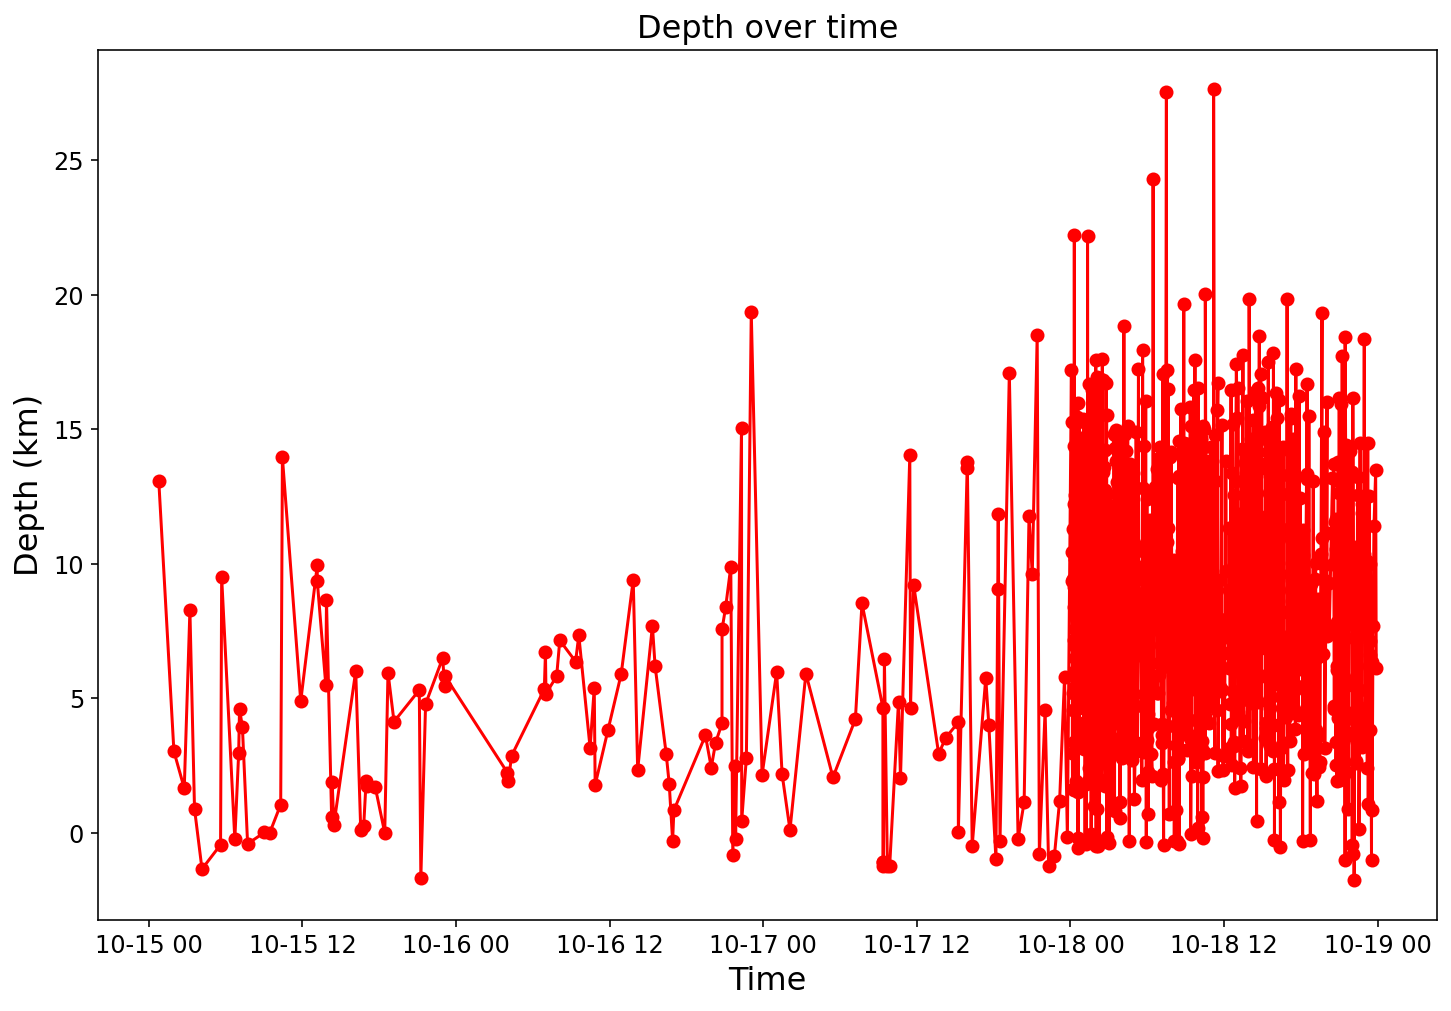

In [29]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_eq["depth"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (km)', fontsize=16)
plt.title('Depth over time', fontsize=16);

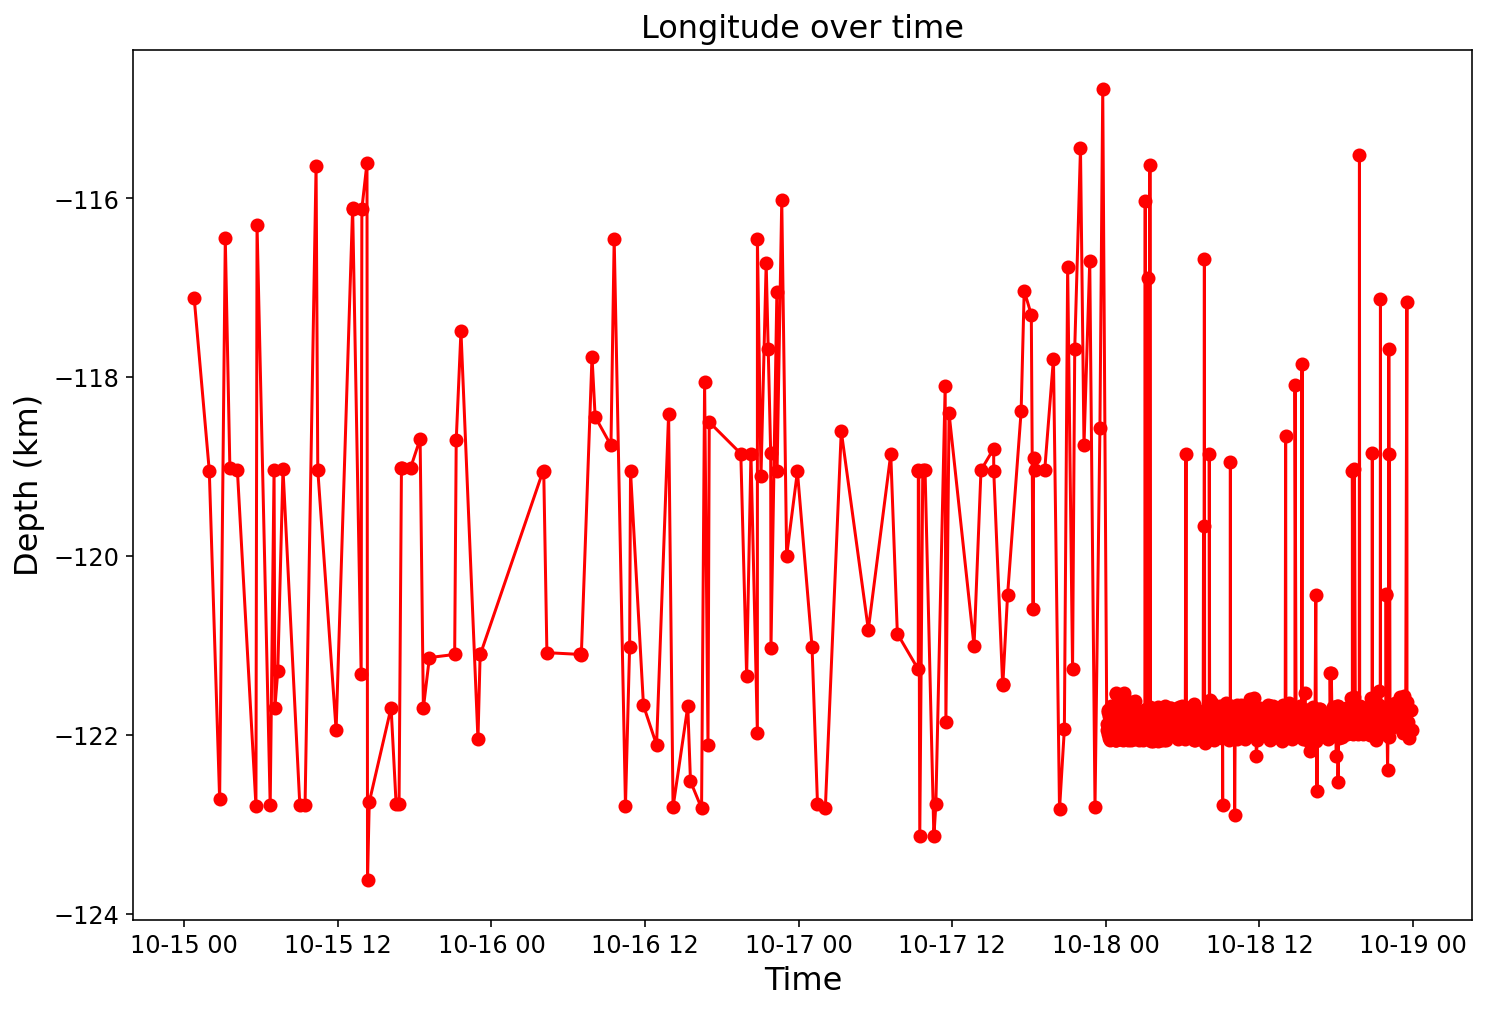

In [32]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_eq["longitude"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (km)', fontsize=16)
plt.title('Longitude over time', fontsize=16);

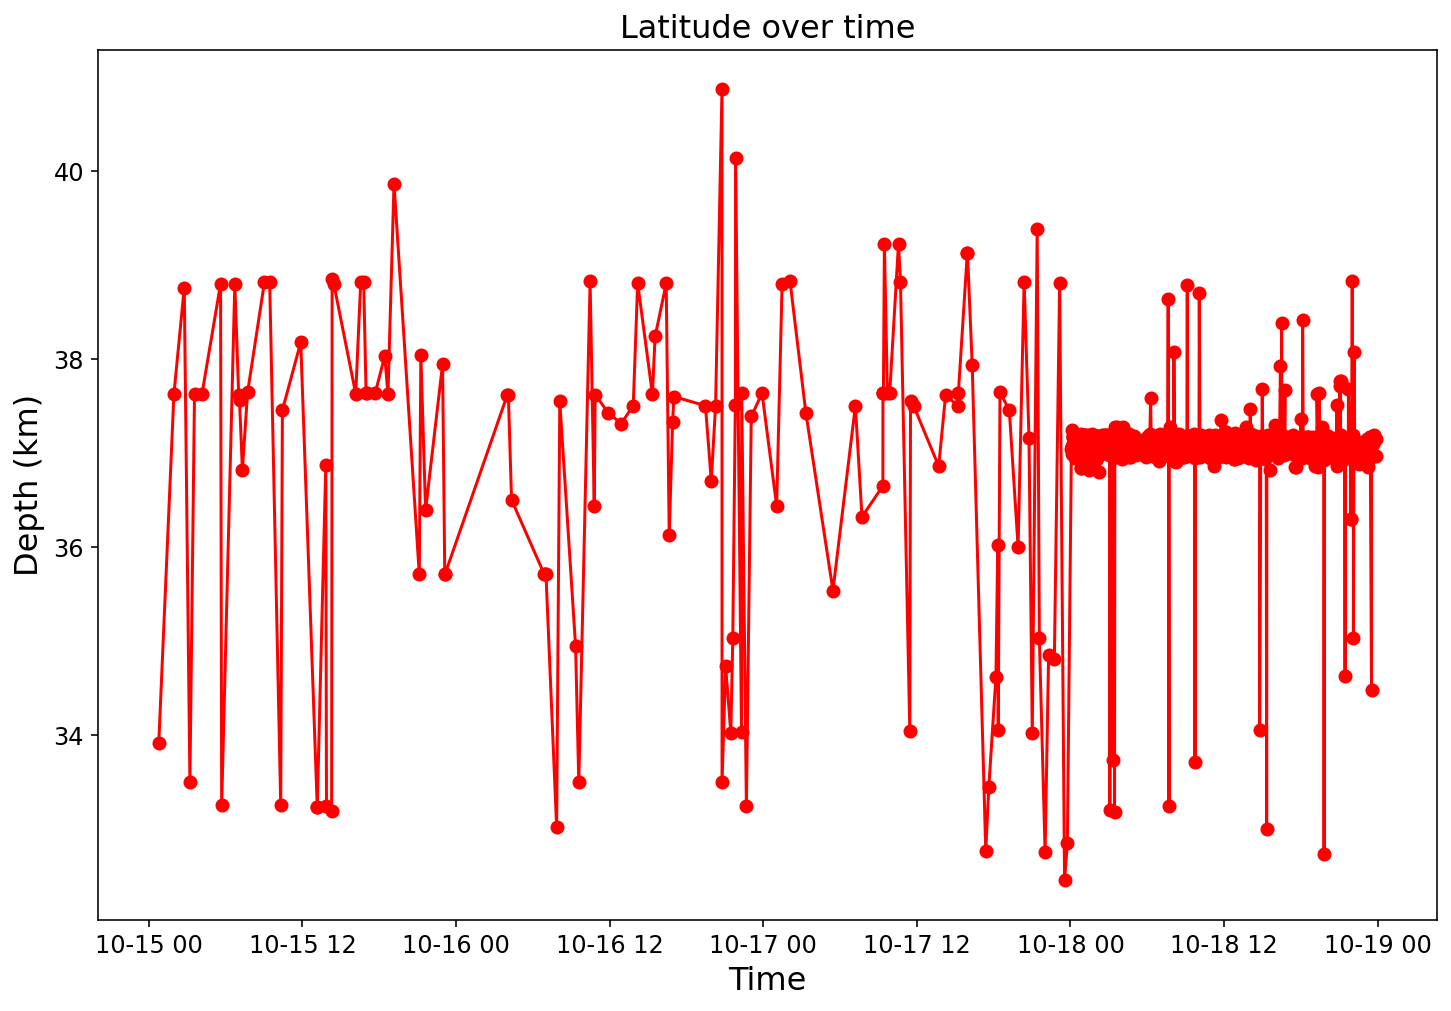

In [33]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_eq["latitude"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (km)', fontsize=16)
plt.title('Latitude over time', fontsize=16);

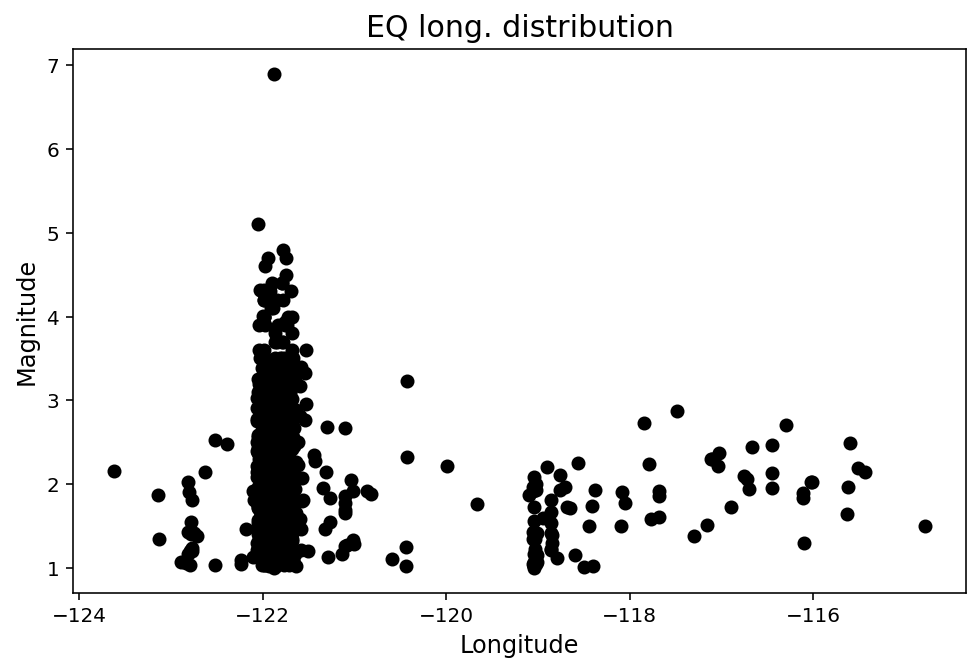

In [31]:
plt.figure(figsize = [8, 5])

plt.scatter(df_eq["longitude"], df_eq["mag"], color="black");

# Format title and axis labels
plt.title("EQ long. distribution", fontsize = 15);

plt.xlabel("Longitude", fontsize = 12);
plt.ylabel("Magnitude", fontsize = 12);

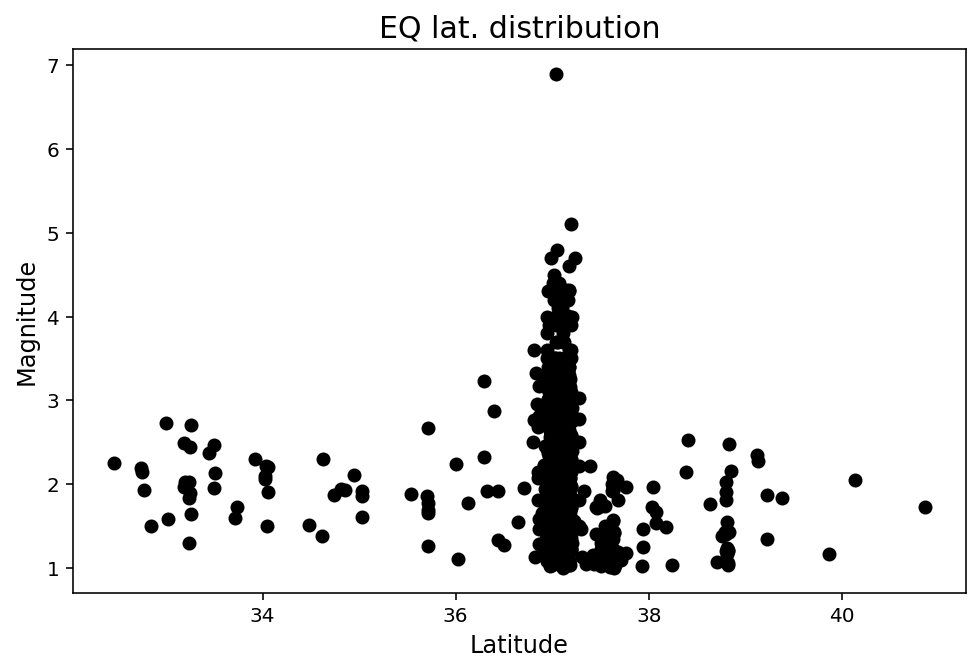

In [30]:
plt.figure(figsize = [8, 5])

plt.scatter(df_eq["latitude"], df_eq["mag"], color="black");

# Format title and axis labels
plt.title("EQ lat. distribution", fontsize = 15);

plt.xlabel("Latitude", fontsize = 12);
plt.ylabel("Magnitude", fontsize = 12);

In [35]:
print("Hello World!")

Hello World!
